# Centroiding with *ballet*

:::{important}
You need to install the JAX dependencies to use this model

```bash
pip install "eloy[jax]"
```

:::


To use the [Ballet](eloy.ballet.model.Ballet) centroiding model in your pipelines, first instantiate the model

In [1]:
from eloy.ballet import Ballet

cnn = Ballet()

And then use it in [eloy.centroid.ballet_centroid](eloy.centroid.ballet_centroid). Here is an example on one of the [calibrated image dataset](calibration)

In [2]:
from astropy.io import fits
from eloy import detection, centroid
import numpy as np

image = fits.getdata("calibrated_images/ESPC WASP-1245.000secs00000009.fits").astype(
    float
)
regions = detection.stars_detection(image)
coords = np.array([region.centroid_weighted[::-1] for region in regions])

centroids = centroid.ballet_centroid(image, coords, cnn)

## The model

Ballet is a convolutional neural network that computes the centroid of star cutouts. It is as accurate as fitting a 2D Gaussian to the profile but ~20x faster. Let's show that on our image.

### Speed

We compute the evaluation time from photutils `centroid_2dg` function against [eloy.centroid.ballet_centroid](eloy.centroid.ballet_centroid)

In [3]:
from photutils.centroids import centroid_2dg

%timeit centroid.photutils_centroid(image, coords, centroid_fun=centroid_2dg)
%timeit centroid.ballet_centroid(image, coords, cnn)

223 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


11.1 ms ± 802 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Precision

As for the precision, let's simulate a set of Moffat profiles and compare the `centroid_2dg` function to [Ballet](eloy.ballet.model.Ballet).

In [4]:
from eloy.ballet.training import Moffat2D
from photutils.centroids import centroid_2dg, centroid_1dg, centroid_quadratic

cutouts, truth = Moffat2D(15).random_model_label(10000)

# these will take a while
centroid_c2dg = np.array([centroid_2dg(cutout)[::-1] for cutout in cutouts[..., 0]])
centroid_c1dg = np.array([centroid_1dg(cutout)[::-1] for cutout in cutouts[..., 0]])
centroid_qd = np.array([centroid_quadratic(cutout)[::-1] for cutout in cutouts[..., 0]])

centroid_ballet = cnn.centroid(cutouts[..., 0])[:, ::-1]

    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]


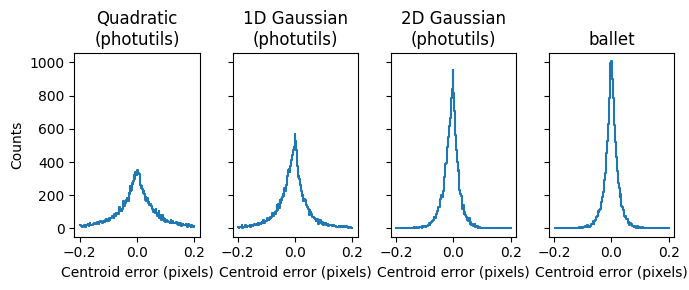

In [5]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(7, 3))
bins = np.linspace(-0.2, 0.2, 200)
offset = 0.01

methods = [centroid_qd, centroid_c1dg, centroid_c2dg, centroid_ballet]
names = [
    "Quadratic\n(photutils)",
    "1D Gaussian\n(photutils)",
    "2D Gaussian\n(photutils)",
    "ballet",
]
for i, method in enumerate(methods):
    axes[i].step(
        bins[1:],
        np.histogram((method - truth), bins)[0],
    )
    axes[i].set_title(names[i])
    axes[i].set_xlabel("Centroid error (pixels)")


axes[0].set_ylabel("Counts")

plt.tight_layout()

As precise as photutils 2D Gaussian fit, but much faster!